# **Dys-Locate**
### Loading the data

In [2]:
import os
import librosa
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=FutureWarning)

In [4]:
dataset_dir = "D://Abhinav//Test//SPR_Project//torgo//"

In [5]:
file_paths = []
labels = []

In [6]:
label_mapping = {
    "F_Con": 0, # 0 for Control
    "M_Con": 0,
    "F_Dys": 1, # 1 for Dysarthric
    "M_Dys": 1
}

In [7]:
for folder, label in label_mapping.items():
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.exists(folder_path):
        # traverse all the subdirectories
        for subdir, _, files in os.walk(folder_path):
            for file in files:
                if file.lower().endswith(".wav"):
                    file_paths.append(os.path.join(subdir, file))
                    labels.append(label)

In [8]:
# create a dataframe for easier handling
data = pd.DataFrame({"file_path": file_paths, "label":labels})
print(f"Found {len(data)} audio_files")
print(data)

Found 17635 audio_files
                                               file_path  label
0      D://Abhinav//Test//SPR_Project//torgo//F_Con\w...      0
1      D://Abhinav//Test//SPR_Project//torgo//F_Con\w...      0
2      D://Abhinav//Test//SPR_Project//torgo//F_Con\w...      0
3      D://Abhinav//Test//SPR_Project//torgo//F_Con\w...      0
4      D://Abhinav//Test//SPR_Project//torgo//F_Con\w...      0
...                                                  ...    ...
17630  D://Abhinav//Test//SPR_Project//torgo//M_Dys\w...      1
17631  D://Abhinav//Test//SPR_Project//torgo//M_Dys\w...      1
17632  D://Abhinav//Test//SPR_Project//torgo//M_Dys\w...      1
17633  D://Abhinav//Test//SPR_Project//torgo//M_Dys\w...      1
17634  D://Abhinav//Test//SPR_Project//torgo//M_Dys\w...      1

[17635 rows x 2 columns]


### Data Preprocessing

In [9]:
import librosa
import numpy as np

def preprocess_audio(file_path, target_sr=16000):
    """
    Load audio, normalize sample rate, trim silence, and normalize amplitude.
    """
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=target_sr)
        # Trim silence
        y, _ = librosa.effects.trim(y)
        # Normalize amplitude
        y = librosa.util.normalize(y)
        return y
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Return None if there is an error

# Initialize a list for processed audio
processed_audio = []

# Preprocess audio files and handle errors
for i, row in data.iterrows():
    audio = preprocess_audio(row["file_path"])
    if audio is not None:  # Only append if the audio was successfully processed
        processed_audio.append(audio)
    else:
        processed_audio.append(np.nan)  # Optionally mark this as NaN or leave it blank

# Check for length mismatch
print(f"Original DataFrame length: {len(data)}")
print(f"Processed audio length: {len(processed_audio)}")

# Optionally, remove rows where processing failed (if you marked them with NaN)
data["processed_audio"] = processed_audio
data = data.dropna(subset=["processed_audio"])  # Remove rows with NaN values
print(f"Data length after dropping NaN rows: {len(data)}")

# Optionally, save the DataFrame to a pickle file for future use
data.to_pickle("processed_data.pkl")

print("Preprocessing completed. Processed data saved.")

Error processing D://Abhinav//Test//SPR_Project//torgo//F_Con\wav_arrayMic_FC01S01\wav_arrayMic_FC01S01_0256.wav: zero-size array to reduction operation maximum which has no identity
Error processing D://Abhinav//Test//SPR_Project//torgo//F_Dys\wav_headMic_F01\wav_headMic_F01_0067.wav: 
Error processing D://Abhinav//Test//SPR_Project//torgo//F_Dys\wav_headMic_F01\wav_headMic_F01_0068.wav: 
Original DataFrame length: 17635
Processed audio length: 17635
Data length after dropping NaN rows: 17632
Preprocessing completed. Processed data saved.


### Extract MFCCs

In [10]:
data.columns

Index(['file_path', 'label', 'processed_audio'], dtype='object')

In [11]:
from concurrent.futures import ThreadPoolExecutor

def extract_mfcc(audio, sr=16000, n_mfcc=20):
    """Extract MFCC features from an audio signal."""
    if audio is None:
        return np.nan  # Handle cases where audio is None
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)  # Take the mean for each coefficient
    return mfcc_mean

def process_row(row):
    """Helper function to process a single row of the DataFrame."""
    audio = row['processed_audio']
    return extract_mfcc(audio)

# Use ThreadPoolExecutor for parallel processing
def parallel_mfcc_extraction(data, n_mfcc=20, max_workers=4):
    """Extract MFCC features in parallel for a DataFrame."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Map each row to the process_row function
        results = list(executor.map(process_row, [row for _, row in data.iterrows()]))
        
    data['mfcc_features'] = results
    return data


data = parallel_mfcc_extraction(data, n_mfcc=20, max_workers=4)

In [12]:
# Define the number of files to select per class
#max_files_per_class = 50  # Adjust as needed

# Group by 'label' and sample 'max_files_per_class' from each group
#limited_data = data.groupby('label').apply(lambda x: x.sample(min(len(x), max_files_per_class))).reset_index(drop=True)

# Perform parallel MFCC extraction on the balanced subset
#limited_data = parallel_mfcc_extraction(limited_data, n_mfcc=13, max_workers=4)

# Update the original DataFrame with the processed subset
#data.loc[limited_data.index, 'mfcc_features'] = limited_data['mfcc_features']


In [13]:
data.head()

,file_path,label,processed_audio,mfcc_features
0,D://Abhinav//Test//SPR_Project//torgo//F_Con\w...,0,"[0.0, 0.0, 0.0, 0.0, -6.0295446e-05, 0.0, 0.0,...","[-253.71657, 31.162016, 2.9564877, 9.534509, 1..."
1,D://Abhinav//Test//SPR_Project//torgo//F_Con\w...,0,"[0.053145338, 0.067425884, 0.018197156, 0.0009...","[-234.1454, 41.158607, -7.435175, 7.7617, 17.3..."
2,D://Abhinav//Test//SPR_Project//torgo//F_Con\w...,0,"[-0.42146754, -0.8386901, -0.38872042, -0.1164...","[-126.86522, -9.7403, 35.861446, -1.6804035, 1..."
3,D://Abhinav//Test//SPR_Project//torgo//F_Con\w...,0,"[-0.0037484886, 0.007859734, 0.019226119, 0.02...","[-152.81413, 60.211166, 10.757963, 16.713995, ..."
4,D://Abhinav//Test//SPR_Project//torgo//F_Con\w...,0,"[-0.024456188, -0.047314737, -0.03809758, -0.0...","[-248.52745, 5.1236978, 19.085815, -4.6721597,..."


### Prpare data for Model Training

In [14]:
from sklearn.model_selection import train_test_split

# Split the data into features (X) and labels (y)
X = data['mfcc_features']
y = data['label'] # Labels for classification

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# If we need to rejoin X_train, X_test with their corresponding 'file_path' or 'processed_audio' columns
train_data = data.loc[X_train.index]
test_data = data.loc[X_test.index]

# Display the split data
print(f'Training set size: {train_data.shape}')
print(f'Testing set size: {test_data.shape}')

Training set size: (14105, 4)
Testing set size: (3527, 4)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(np.vstack(X_train))
X_test_normalized = scaler.transform(np.vstack(X_test))

print(f"Normalized training data shape: {X_train_normalized.shape}")
print(f"Normalized testing data shape: {X_test_normalized.shape}")

Normalized training data shape: (14105, 20)
Normalized testing data shape: (3527, 20)


### Prepare labels

In [16]:
import tensorflow

num_classes = len(np.unique(y_train))
y_train_encoded = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tensorflow.keras.utils.to_categorical(y_test, num_classes)

print(f"Encoded training labels shape: {y_train_encoded.shape}")
print(f"Encoded testing labels shape: {y_test_encoded.shape}")

Encoded training labels shape: (14105, 2)
Encoded testing labels shape: (3527, 2)


### Build a fully connected network

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [18]:
# Define the model
model = Sequential([
    Dense(64, input_shape=(20,), activation='relu'),  # Input layer
    Dropout(0.3),                                    # Regularization
    Dense(32, activation='relu'),                    # Hidden layer
    Dropout(0.3),
    Dense(num_classes, activation='softmax')         # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,490 (13.63 KB)

 Trainable params: 3,490 (13.63 KB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [19]:
# Train the model
history = model.fit(
    X_train_normalized, y_train_encoded,
    validation_data=(X_test_normalized, y_test_encoded),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6986 - loss: 0.5810 - val_accuracy: 0.8330 - val_loss: 0.3904
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8206 - loss: 0.4138 - val_accuracy: 0.8735 - val_loss: 0.3202
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8480 - loss: 0.3623 - val_accuracy: 0.8869 - val_loss: 0.2864
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8681 - loss: 0.3372 - val_accuracy: 0.8942 - val_loss: 0.2667
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8809 - loss: 0.2919 - val_accuracy: 0.9067 - val_loss: 0.2497
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8841 - loss: 0.2846 - val_accuracy: 0.9084 - val_loss: 0.2303
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8919 - loss: 0.2774 - val_accuracy: 0.9132 - val_loss: 0.2208
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9018 - loss: 0.2528 - val_accuracy: 0.

### Evaluate the Model

In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 58/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.1840

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9316 - loss: 0.1780
Test Loss: 0.16741502285003662
Test Accuracy: 0.9350723028182983


### Analyze the Results

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


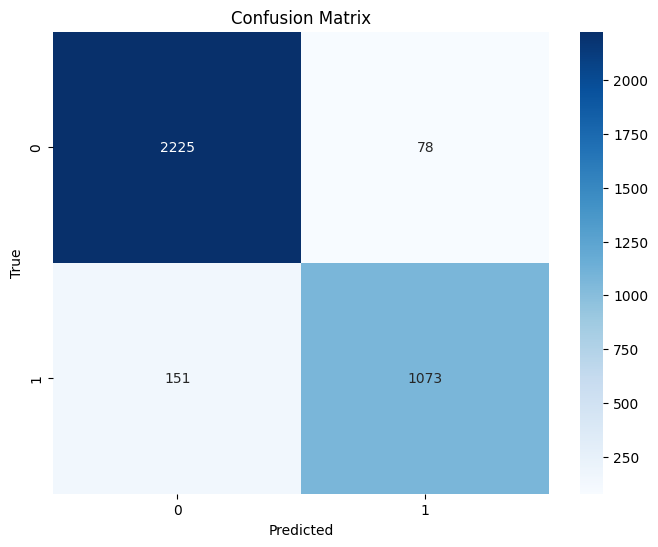

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2303
           1       0.93      0.88      0.90      1224

    accuracy                           0.94      3527
   macro avg       0.93      0.92      0.93      3527
weighted avg       0.93      0.94      0.93      3527



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes))

### Understanding the Confusion Matrix
- **True Negatives (TN) - Top-left `(2252)`**: These are samples that were correctly classified as class 0 (negative class).

- **False Positives (FP) - Top-right `(51)`**: These are samples that were actually class 0 but were incorrectly predicted as class 1.

- **False Negatives (FN) - Bottom-left `(185)`**: These are samples that were actually class 1 but were incorrectly predicted as class 0.

- **True Positives (TP) - Bottom-right `(1039)`**: These are samples that were correctly classified as class 1 (positive class).

# Check for Overfitting

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_normalized, y_train_encoded,
    validation_data=(X_test_normalized, y_test_encoded),
    epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1
)

Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9240 - loss: 0.1978 - val_accuracy: 0.9325 - val_loss: 0.1656
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9253 - loss: 0.1934 - val_accuracy: 0.9359 - val_loss: 0.1645
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9238 - loss: 0.1850 - val_accuracy: 0.9345 - val_loss: 0.1582
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9301 - loss: 0.1800 - val_accuracy: 0.9356 - val_loss: 0.1566
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9315 - loss: 0.1879 - val_accuracy: 0.9427 - val_loss: 0.1560
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9299 - loss: 0.1778 - val_accuracy: 0.9390 - val_loss: 0.1603
Epoch 7/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9292 - loss: 0.1796 - val_accuracy: 0.9368 - val_loss: 0.1570
Epoch 8/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9323 - loss: 0.1791 - val_accuracy: 0.

### Visualize Trianing Process

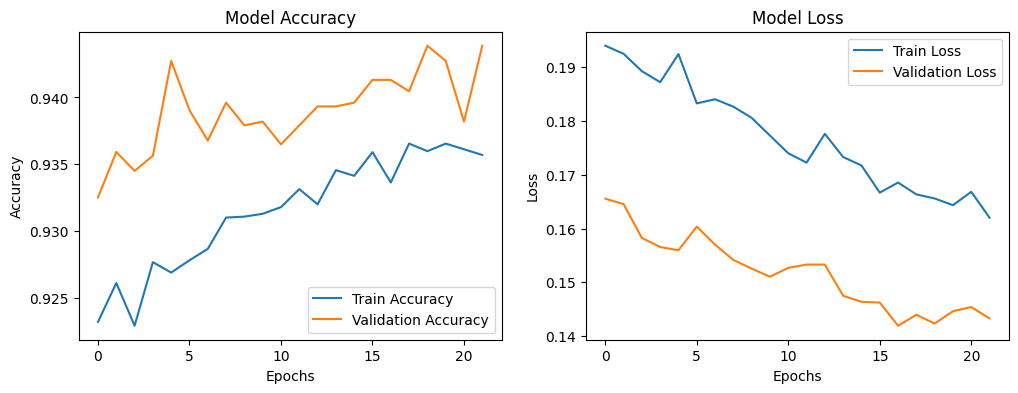

In [23]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

### Deploying the Model

In [24]:
model.save('dysarthria_detection_model.h5')

### Testing

In [25]:
import random
import numpy as np

# Select a random sample from the DataFrame
random_index = random.randint(0, len(data) - 1)
sample = data.iloc[random_index]

# Extract the file path and true label
sample_file_path = sample['file_path']
true_label = sample['label']  # Assuming 'label' is the true class

# Preprocess the audio (e.g., extracting features, normalizing)
# Assuming 'processed_audio' and 'mfcc_features' are already populated
sample_features = sample['mfcc_features']  # Replace with appropriate column if necessary
sample_features = np.array(sample_features)

# Normalize the features (use the same method as during training)
sample_features_normalized = sample_features / np.max(sample_features)

# Reshape for the model (if necessary)
sample_features_reshaped = sample_features_normalized.reshape(1, -1)  # Adjust shape based on your model input

# Make a prediction
prediction_probabilities = model.predict(sample_features_reshaped)
predicted_label = np.argmax(prediction_probabilities, axis=1)[0]

# Compare with the true label
print(f"File Path: {sample_file_path}")
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {prediction_probabilities}")

# Check if the prediction matches the true label
if true_label == predicted_label:
    print("✅ The model predicted correctly!")
else:
    print("❌ The model predicted incorrectly.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
File Path: D://Abhinav//Test//SPR_Project//torgo//M_Dys\wav_headMic_M02S01\wav_headMic_M02S01_0082.wav
True Label: 1
Predicted Label: 1
Prediction Probabilities: [[6.266644e-05 9.999373e-01]]
✅ The model predicted correctly!
